In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load in data

In [2]:
# First subject
sub_XC = np.genfromtxt('../data/rsfMRI_timeseries/sub-XC_parcellated_timeseries.txt')

# Second subject
sub_XA = np.genfromtxt('../data/rsfMRI_timeseries/sub-XA_parcellated_timeseries.txt')

In [4]:
# Looking at the shape of the data we just loaded in, we see it's 333 rows and 6000 columns

# The 333 rows represent 333 functionally homogonous regions of cortex known as "parcels"
# The 6000 columns represent 6000 frames of BOLD activity at each parcel

print(sub_XC.shape)
print(sub_XA.shape)

(333, 6000)
(333, 6000)


In [5]:
# OK that works for two subjects, what if you wanted to load in many?

# You'll want a list of all subjects in the analysis. This could be saved in a text file.
sub_list = np.genfromtxt('../data/sub_list.txt', str)
print(sub_list)

#Then you'll loop through the list and read in each subjects data.
data_dir = '../data/rsfMRI_timeseries'
rsfmri_data = np.zeros((len(sub_list),333,6000))

for i,sub in enumerate(sub_list):
    path_to_read = os.path.join(data_dir, f'sub-{sub}_parcellated_timeseries.txt')
    subject_data = np.genfromtxt('../data/rsfMRI_timeseries/sub-XA_parcellated_timeseries.txt')
    rsfmri_data[i] = subject_data

['XC' 'XA']


In [6]:
# Data structure holding all participants data in the order presented in sub_list
print(rsfmri_data.shape)

(2, 333, 6000)


# Create "functional connectivity" from the resting state fMRI timeseries data

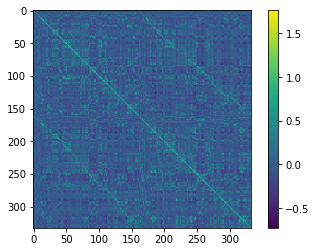

In [7]:
# Functional connectivity is the correlation structure between the timeseries at different brain regions

# np.corrcoef returns a correlation matrix that gives the correlation between all pairs of parcels (rows)
sub_XC_rsFC = np.corrcoef(sub_XC)

# We apply a Fisher Z-Transformation
np.fill_diagonal(sub_XC_rsFC, 0)
sub_XC_rsFC = np.arctanh(sub_XC_rsFC)
np.fill_diagonal(sub_XC_rsFC, 1)

# plt.imshow can be used to quickly view the correlation matrix we just created
plt.imshow(sub_XC_rsFC)
plt.colorbar()
plt.show()

In [8]:
# OK that works for one subject. What if we wanted to do create the correlation matrix for everyone?

# First, create a function that takes in a the rsFMRI timeseries data, and outputs the z-transformed connectivty
def create_corrmat(ts):
    corrmat = np.corrcoef(ts)
    np.fill_diagonal(corrmat, 0)
    corrmat = np.arctanh(corrmat)
    np.fill_diagonal(corrmat, 1)
    return corrmat

# Then, apply that function to every participant. 
rsfc_data = np.zeros((len(sub_list),333,333))

# Loop though the participants in the rsFMRI data struture, create and store the correlation matricies
for i,sub in enumerate(rsfmri_data):
    rsfc_data[i] = create_corrmat(sub)

# Now we have connectivity data for each participant
print(rsfc_data.shape)

(2, 333, 333)


# Data exploration

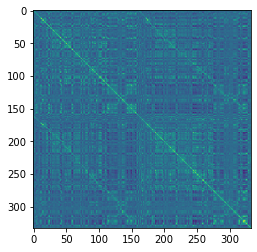

In [10]:
# One thing we may want to do is sisualize the mean connectivity of the group. plt.imshow is an easy way to do this

plt.imshow(rsfc_data.mean(0))
plt.show()

In [16]:
# We can see that the correlation matrix is currently unordered. It doesn't display the block-diagnal structure
# Representing groupings of highly correlated brain regions ('functional networks')

# One way to visualize functional networks is to re-order the parcels based off the community structure
# in the graph created by the above (or similar, group averaged) correlation matrixs

# First we load in the community structure from a group averaeg graph, created off this parcel set 
# Generation and Evaluation of a Cortical Area Parcellation from Resting-State Correlations (Gordon et al., 2016)

parcel_labels = pd.read_excel('../data/Parcels.xlsx')
parcel_labels

/Users/matt/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,ParcelID,Hem,Surface area (mm2),Centroid (MNI),Community
0,1,L,1411.6436,-11.2 -52.4 36.5,Default
1,2,L,377.2543,-18.8 -48.7 65,SMhand
2,3,L,437.1466,-51.8 -7.8 38.5,SMmouth
3,4,L,368.6362,-11.7 26.7 57,Default
4,5,L,870.9255,-18.4 -85.5 21.6,Visual
...,...,...,...,...,...
328,329,R,15.9589,39.7 -22.5 2.6,Auditory
329,330,R,415.3981,55.8 2 -2,Auditory
330,331,R,101.3923,54.4 1.1 -12.9,Default
331,332,R,129.5680,57.1 -6.3 -7.7,VentralAttn


In [23]:
# This gives us information on each of the 333 parcels. We are currently interested in the 'Community' column
# Specifically, we want to sort the parcels by their canonical community label.

communities = parcel_labels['Community']

array(['Auditory', 'CinguloOperc', 'CinguloParietal', 'Default',
       'DorsalAttn', 'FrontoParietal', 'None', 'RetrosplenialTemporal',
       'SMhand', 'SMmouth', 'Salience', 'VentralAttn', 'Visual'],
      dtype=object)